# Fine tuning Azure Open AI Models for Data classification problem

In this notebook we will learn to fine tune Azure open AI models to perform a data classification.

For data classifiction using Open AI this notebook is divided into 3 sections

1. Load Data
2. Analysis
3. Data Preparation
4. Training
5. Validation
6. Model Deployment
7. Inference.

For the second half of the notebook we build a simple random forest classifier. 
We will also further develop insights into which models is recommended, cost implications, drawbacks of each. 


In [43]:
# Env variables
import os
import openai
from dotenv import load_dotenv
import openai
from openai import cli
import time
import numpy as np
from sklearn.datasets import load_files
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Azure
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_DEPLOYMENT_ENDPOINT = os.getenv("OPENAI_DEPLOYMENT_ENDPOINT")
OPENAI_DEPLOYMENT_NAME = os.getenv("OPENAI_DEPLOYMENT_NAME")
OPENAI_MODEL_NAME = os.getenv("OPENAI_MODEL_NAME")
OPENAI_EMBEDDING_DEPLOYMENT_NAME = os.getenv("OPENAI_EMBEDDING_DEPLOYMENT_NAME")
OPENAI_EMBEDDING_MODEL_NAME = os.getenv("OPENAI_EMBEDDING_MODEL_NAME")
OPENAI_DEPLOYMENT_VERSION = os.getenv("OPENAI_DEPLOYMENT_VERSION")
OPENAI_EMBEDDING_VERSION = os.getenv("OPENAI_EMBEDDING_VERSION")
AZURE_SUBSCRIPTION_ID = os.getenv("AZURE_SUBSCRIPTION_ID")

#init Azure OpenAI
openai.api_type = "azure"
openai.api_version = OPENAI_DEPLOYMENT_VERSION
openai.api_base = OPENAI_DEPLOYMENT_ENDPOINT
openai.api_key = OPENAI_API_KEY

## 1. Load Data

In this sample we will classify text that belong to 10 different categories like - technologie, sports, social etc.<br/>
The data can be downloaded from here https://drive.google.com/file/d/17vbWKQXFQu9qkOCps2z6Oi18ntT4FIuH/view?usp=sharing

In [44]:
# download data and name the folder as data.
if os.getcwd().endswith('data') == False:
    os.chdir("./data")

In [45]:
# load data from files
data = load_files(".", encoding="utf-8", decode_error="replace")

In [46]:
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
# df = df.groupby('label').head(10).reset_index(drop=True)
# rename columns to meet the OpenAI requirements
df.rename(columns={'text':'prompt', 'label':'completion'}, inplace=True)
# convert label to string for padding
df.completion = df.completion.apply(lambda x : data.target_names[x])
df.head()

,prompt,completion
0,The future in your pocket\n\nIf you are a geek...,technologie
1,Brizzel to run AAA's in Sheffield\n\nBallymena...,sport
2,Fish and shellfish are both great sources of l...,food
3,JB> romdas@uclink.berkeley.edu (Ella I Baff) ...,medical
4,Tory leader unveils spending plan\n\nTory lead...,politics


In [47]:
num_of_classes = len(set(np.array(df.completion)))
print(f"Number of classes: {num_of_classes}")

Number of classes: 10


In [48]:
# files per class
df.groupby('completion').count()

,prompt
completion,
business,10
entertainment,10
food,10
graphics,10
historical,10
medical,10
politics,10
space,10
sport,10


## 2. Analysis 

In [49]:
# plot distribution of classes
df["num_of_words"] = df.prompt.apply(lambda x : len(x.split()))
df_graph = df['num_of_words'].groupby([df['completion']]).describe(percentiles=[0.95])
df_graph = df_graph.reset_index()
df_graph.sort_values(by=['max'], ascending=False).head(10)

,completion,count,mean,std,min,50%,95%,max
7,space,10.0,546.9,787.612066,66.0,219.0,2002.80,2496.0
4,historical,10.0,760.2,479.241484,82.0,829.5,1364.50,1486.0
9,technologie,10.0,516.0,221.323795,197.0,516.0,801.75,822.0
1,entertainment,10.0,285.3,143.199977,184.0,250.5,513.15,672.0
6,politics,10.0,431.6,114.269856,194.0,438.0,555.05,569.0
8,sport,10.0,282.6,126.779949,142.0,255.0,486.25,511.0
5,medical,10.0,160.9,110.066091,31.0,137.5,335.95,430.0
0,business,10.0,270.0,60.999089,147.0,302.5,317.85,321.0
3,graphics,10.0,165.2,96.301379,51.0,165.5,275.75,278.0
2,food,10.0,205.1,50.364119,125.0,212.0,268.45,277.0


<Axes: title={'center': 'Max number of words per class'}, xlabel='completion'>

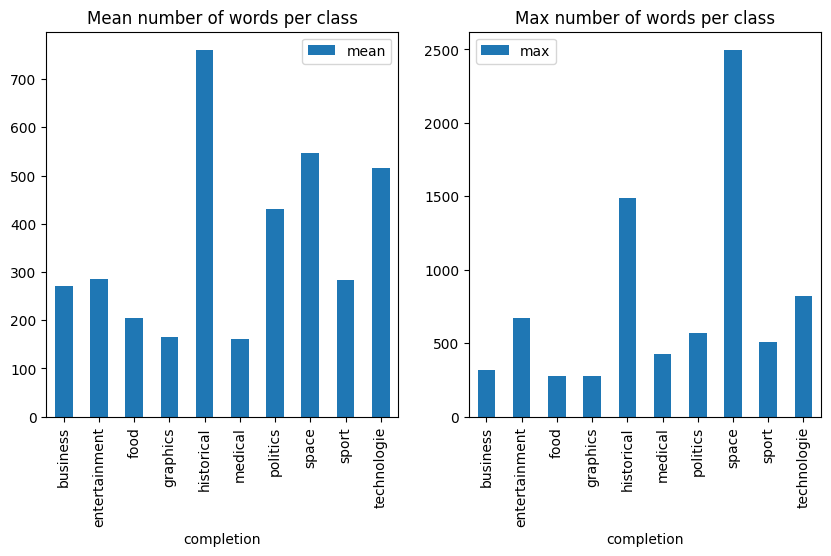

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_graph.plot(x='completion', y='mean', kind='bar', figsize=(10, 5), title='Mean number of words per class', ax=axes[0])
df_graph.plot(x='completion', y='max', kind='bar', figsize=(10, 5), title='Max number of words per class', ax=axes[1])


Key Insights
- Graphics category has the largest text followed by medical, space.
- Graphics is also skewed because min, max and 95% have huge variation
- Food category has lowest words.

## 3. Data Preparation

In [51]:
df = df.drop(columns=['num_of_words'])
# Each prompt should end with a fixed separator to inform the model when the prompt ends and the completion begins. 
# A simple separator which generally works well is \n\n###\n\n. The separator should not appear elsewhere in any prompt.
df.prompt = df.prompt + "\n\n###\n\n"
# Each completion should start with a whitespace due to tokenization, which tokenizes most words with a preceding whitespace.
df.completion = df.completion.apply(lambda x: " " + x)
df.prompt[0][-10:], df.completion[0]

('h.\n\n\n###\n\n', ' technologie')

In [52]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print(df_train.shape)
print(df_test.shape)
df_train.head()

(80, 2)
(20, 2)


,prompt,completion
55,I am looking for the email address of the Worl...,medical
88,Gurkhas to help tsunami victims\n\nBritain has...,politics
26,Peugeot deal boosts Mitsubishi\n\nStruggling J...,business
42,Blair congratulates Bush on win\n\nTony Blair ...,politics
69,Mobile networks seek turbo boost\n\nThird-gene...,technologie


In [53]:
# # Define the stop words and stemmer
# stop_words = set(stopwords.words('english'))
# stemmer = SnowballStemmer('english')

# # Preprocess the data
# def preprocess_text(text):
#     # Remove punctuation and lowercase the text
#     text = ''.join(c for c in text if c.isalnum() or c.isspace())
#     text = text.lower()

#     # Remove stop words and stem the words
#     words = [stemmer.stem(word) for word in text.split() if word not in stop_words]

#     # Join the words back into a string
#     return ' '.join(words)

# # Preprocess the train and test data
# df_train.prompt = [preprocess_text(text) for text in df_train.prompt]
# df_test.prompt = [preprocess_text(text) for text in df_test.prompt]

In [54]:
# creating training files in JSONL format
training_file_name = "news_ds_train.jsonl"
test_file_name = "news_ds_test.jsonl"
df_train.to_json(training_file_name, orient='records', lines=True)
df_test.to_json(test_file_name, orient='records', lines=True)

In [55]:
# uploading the training files to Azure OpenAI Studio
training_id  = cli.FineTune._get_or_upload(training_file_name, False)
validation_id = cli.FineTune._get_or_upload(test_file_name, False)

Upload progress: 100%|██████████| 169k/169k [00:00<00:00, 84.5Mit/s]


Uploaded file from news_ds_train.jsonl: file-4084229e61dc4ef3a97ff8d39d22e88d


Upload progress: 100%|██████████| 68.0k/68.0k [00:00<00:00, 34.0Mit/s]


Uploaded file from news_ds_test.jsonl: file-482eec54b85f4ca588d5da6e1f0f2cf3


## 4. Training

In [56]:
# create a customized model with training and validation data. 
# The model will be trained for 1 epoch and will compute classification metrics.
create_args = {
    "training_file": training_id,
    "validation_file": validation_id,
    "model": "ada",
    "n_epochs": 1,
    "compute_classification_metrics": True,
    "classification_n_classes": num_of_classes
}

# Create the fine-tune job and retrieve the job ID
# and status from the response.
resp = openai.FineTune.create(**create_args)
job_id = resp["id"]
status = resp["status"]

# You can use the job ID to monitor the status of the fine-tune job.
# The fine-tune job may take some time to start and complete.
print(f'Fine-tuning model with job ID: {job_id}.')

InvalidRequestError: The specified file reference must point to a completed file import.

In [ ]:
job_id = "ft-01eac8a7be42417eab1eeede7b3753dc"
status = openai.FineTune.retrieve(id=job_id)["status"]

# If the job isn't yet done, poll it every 2 seconds.
if status not in ["succeeded", "failed"]:
    print(f'Job not in terminal status: {status}. Waiting.')
    while status not in ["succeeded", "failed"]:
        time.sleep(10)
        status = openai.FineTune.retrieve(id=job_id)["status"]
        print(f'Status: {status}')
else:
    print(f'Fine-tune job {job_id} finished with status: {status}')


Fine-tune job ft-01eac8a7be42417eab1eeede7b3753dc finished with status: succeeded


In [ ]:
import io
# verify the trainining results
# Retrieve the fine-tune job
result = openai.FineTune.retrieve(id=job_id)
if result["status"] == 'succeeded':
    result_file_id = result.result_files[0].id
    result_file_name = result.result_files[0].filename
    result_validation_file_id = result.validation_files[0].id
print(f'Downloading result file: {result_file_name}')
with open(result_file_name, "wb") as file:
    result = openai.File.download(id=result_file_id)
    file.write(result)
print(f'Result file {result_file_name} downloaded.')

Result file results.csv downloaded.


In [ ]:
result = openai.FineTune.retrieve(id=job_id)
total_tokens = result.training_files[0].statistics.tokens + result.validation_files[0].statistics.tokens
total_examples = result.training_files[0].statistics.examples + result.validation_files[0].statistics.examples
print(f'Total tokens: {total_tokens}')
print(f'Total examples: {total_examples}')

Total tokens: 36437
Total examples: 100


## 5. Validation

In [ ]:
df_results = pd.read_csv('./results.csv')
df_results.tail(3)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,classification/accuracy,classification/weighted_f1_score
25,26,52062,78,0.264876,0.000000,0.000000,-1.0,-1.000000
26,27,52785,81,0.221623,0.333333,0.333333,-1.0,-1.000000
27,28,54900,84,0.156992,1.000000,1.000000,0.5,0.462143


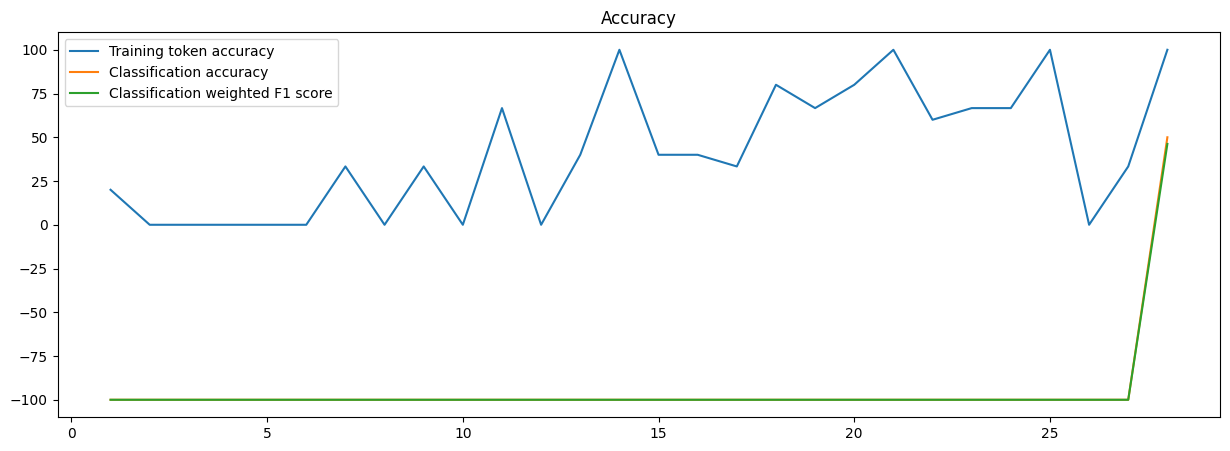

In [ ]:
# Plotting training Loss
training_steps = np.array(df_results.step)
training_loss = np.array(df_results.training_loss)
training_token_accuracy = np.array(df_results.training_token_accuracy*100)
training_classification_accuracy = np.array(df_results["classification/accuracy"]*100)
training_classification_weighted_f1_score = np.array(df_results["classification/weighted_f1_score"]*100)

plt.figure(figsize=(15,5))
plt.plot(training_steps, training_token_accuracy, label='Training token accuracy')
plt.plot(training_steps, training_classification_accuracy, label='Classification accuracy')
plt.plot(training_steps, training_classification_weighted_f1_score, label='Classification weighted F1 score')
plt.title('Accuracy')
plt.legend()


## 6. Model Deployment

The customized model is available for deployment only once. In the below step we will deploy the model, which makes it available for inference using Open AI Completion libraries.
Note: The code that is present online is deprecated. 

In [156]:
# Moving forward (Azure API versions 2023-05-15 and newer), the deployments APIs are deprecated in the openai library. 
# For all code managing deployments, it is recommended to use the azure-mgmt-cognitiveservices client library. 

from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient
from azure.identity import AzureCliCredential

load_dotenv()

sub_id = os.getenv("AZURE_SUBSCRIPTION_ID")
rg_name = os.getenv("RESOURCE_GROUP_NAME")
acc_name = os.getenv("ACCOUNT_NAME")
deployment_name = os.getenv("DEPLOYMENT_NAME")
model_name = ""
model_version = os.getenv("MODEL_VERSION")
tenant_id = os.getenv("TENANT_ID")


result = openai.FineTune.retrieve(id=job_id)
if result["status"] == 'succeeded':
    model_name = result["fine_tuned_model"]

# DefaultAzureCredential supports different authentication mechanisms and determines the appropriate credential type based of the environment it is executing in.
client = CognitiveServicesManagementClient(credential=AzureCliCredential(tenant_id=tenant_id), subscription_id=sub_id)
deployment = client.deployments.begin_create_or_update(
    resource_group_name=rg_name,
    account_name=acc_name,
    deployment_name=deployment_name,
    deployment={
        "properties": {
          "model": {
            "format": "OpenAI",
            "name": model_name,
            "version": model_version
          },
          "scaleSettings": {
            "scaleType": "Standard"
          }
        }
    }
)
result = deployment.result()
print(result)

{'additional_properties': {}, 'id': '/subscriptions/6a01260f-39d6-415f-a6c9-cf4fd479cbec/resourceGroups/sriks-ml-rg/providers/Microsoft.CognitiveServices/accounts/prompt-eng-models/deployments/custom-classification-model-ada-001', 'name': 'custom-classification-model-ada-001', 'type': 'Microsoft.CognitiveServices/accounts/deployments', 'system_data': <azure.mgmt.cognitiveservices.models._models_py3.SystemData object at 0x000001801E4BA610>, 'etag': '"a717c18d-f49c-4aae-8d35-bc49fb74c16c"', 'properties': <azure.mgmt.cognitiveservices.models._models_py3.DeploymentProperties object at 0x000001801EB5FCD0>}


## 7. Inference

In this section we will use the data from validation set to predict the target class.
Similar to fine-tuning, we should update the prompts with additional tokens for the model to accurately predict.
For classifictaion it is recommended to keep the temperature low. 

In [42]:
print('Sending a test completion job')
start_phrase = df_test.sample().prompt.values[0] + "\n\n###\n\n"
target_class = " " + df_test.sample().completion.values[0]
deployment_id = result.id
response = openai.Completion.create(engine=result.name, prompt=start_phrase, max_tokens=1, temperature=0)
text = response['choices'][0]['text'].replace('\n', '').replace(' .', '.').strip()
print(f"{start_phrase}")
print(f"{text} {target_class}")

Sending a test completion job


AttributeError: name

# Random Forest Classifier

In [1]:
# Random Forest Classifier

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt

vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(df_train).toarray()

def create_dataset(dataframe):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].to_numpy(), dataframe["target"].to_numpy())
    )
    dataset = dataset.batch(100)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds = create_dataset(train_df)
test_ds = create_dataset(test_df)

ModuleNotFoundError: No module named 'tensorflow'

In [67]:
# Evaluate the model on the test data
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predicted_labels_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.0


c:\code\openai-samples\.venv\Lib\site-packages\sklearn\metrics\_classification.py:227: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
